In [1]:
# Imports
from jax import config

config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx
from gpjax.typing import Array, Float

from dataclasses import dataclass

from jax import jacfwd, jacrev
import optax as ox

import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# allow interactive plots
# %matplotlib widget

In this notebook, we reproduce a 3D simulation study, using ideas in the [Linearly Constrained Gaussian Processes](https://papers.nips.cc/paper_files/paper/2017/hash/71ad16ad2c4d81f348082ff6c4b20768-Abstract.html) paper.

# 3D Curl-free

## Data processing

We will use the following latent function, which is the gradient of a scalar potential field given by.

$$\mathbf f:\mathbb{R}^D\to\mathbb{R}^K$$

where $D=K=3$, defined by:

$$\mathbf f(\mathbf x) = - \nabla P$$

for:

$$P = - e^{-a (xy+yz+zx)} \sin{(xy+yz+zx)}$$

with $a=0.01$

Importantly, $\boldsymbol \nabla\times \mathbf f = 0$ see eg. [wikipedia](https://en.wikipedia.org/wiki/Vector_calculus_identities#Curl_of_gradient_is_zero). In this notebook, we will exploit this linear constraint to improve Gaussian Process Regression.

In [3]:
def curl_free_3d_example(x, y, z, a=0.01):
    # gradient of the scalar potential: 
    # exp(-a (x*y + y*z + z*x)) * sin(x*y + y*z + z*x)
    argument = x * y + y * z + z * x
    exp_term = np.exp(-a * argument)
    x_trig = (y + z) * np.cos(argument) - a * (y + z) * np.sin(argument)
    y_trig = (x + z) * np.cos(argument) - a * (x + z) * np.sin(argument)
    z_trig = (x + y) * np.cos(argument) - a * (x + y) * np.sin(argument)
    return exp_term * x_trig, exp_term * y_trig, exp_term * z_trig

## In-depth specification

We restrict our focus to the following region: $[0,1]\times [0,1]\times [0,1]$
### Train points
Choose 50 train points uniformly randomly from the region
### Test points
A grid of $n_{\text{divisions}}^3$ points evenly spaced (in each dimension)

### Processing data
Initially the each datum is of the form $(\mathbf x,\mathbf y)$, where $\mathbf x,\mathbf y\in\mathbb{R}^3$.

This is modified to three measurements: $\{((\mathbf x, i), y_i)\}_{i=1}^3$. This ensures that the output is one dimensional, and so the kernel function is scalar valued. Explicitly, denoting the matrix-valued kernel function as $\mathbf K$ and the scalar-valued kernel function as $\tilde K$:

$$K_{ij}(\mathbf x,\mathbf x') = \tilde K((\mathbf x,i),(\mathbf x',j))$$

In [4]:
n_divisions = 5

In [5]:
def label_position_3d(data, inducing=0.0):
    # introduce alternating axis label
    n_points = len(data[0])
    axis_label = jnp.tile(jnp.array([0.0, 1.0, 2.0]), n_points)
    axis_labeled_position = jnp.vstack(
        (jnp.repeat(data, repeats=3, axis=1), axis_label)
    ).T
    # introduce label distinguishing between observations and inducing points
    return jnp.concatenate(
        (axis_labeled_position, inducing * jnp.ones((n_points * 3, 1))), axis=1
    )


def stack_vector(data):
    return data.T.flatten().reshape(-1, 1)


def dataset_5d(pos, obs, inducing=0.0):
    return gpx.Dataset(label_position_3d(pos, inducing), stack_vector(obs))

In [6]:
positions = jnp.mgrid[
    0 : 1 : n_divisions * 1j, 0 : 1 : n_divisions * 1j, 0 : 1 : n_divisions * 1j
].reshape(3, -1)

observations = jnp.stack(
    curl_free_3d_example(positions[0], positions[1], positions[2]), axis=0
).reshape(3, -1)

dataset = dataset_5d(positions, observations)

In [7]:
simulation_key = jr.PRNGKey(0)

# Proposition for training data, unrestricted by a grid
train_positions = jr.uniform(
    key=simulation_key, minval=0., maxval=1., shape=(50, 3)
).reshape(3, -1)

train_observations = jnp.stack(
    curl_free_3d_example(train_positions[0], train_positions[1], train_positions[2]),
    axis=0,
).reshape(3, -1)

# Add noise to the observations, roughly 1% of the mean value
noise = 1e-2
train_observations += noise * jr.normal(simulation_key, train_observations.shape)

training_data = dataset_5d(train_positions, train_observations)

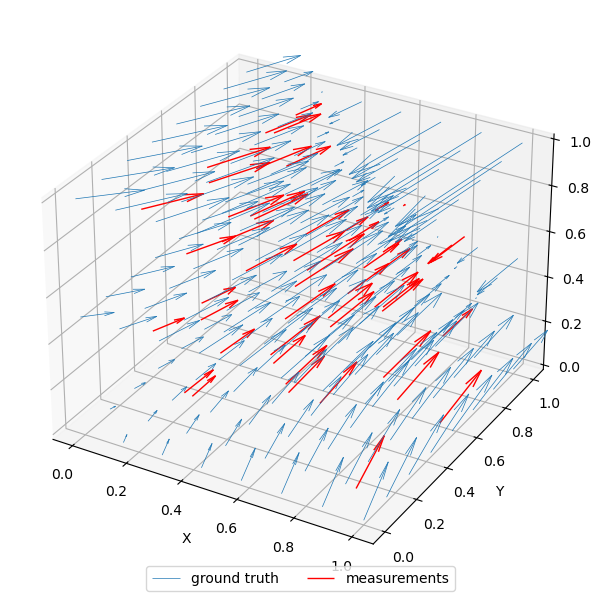

In [8]:
# Ground truth + measurements plot

# Generate a grid of points
x = np.linspace(0, 1, 8)
y = np.linspace(0, 1, 8)
# only 3 points in z direction to avoid clutter
z = np.linspace(0, 1, 3)
X, Y, Z = np.meshgrid(x, y, z)

# Compute the vector field components
U, V, W = curl_free_3d_example(X, Y, Z)

# Create a 3D plot
fig = plt.figure(figsize=(6, 6))

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

ax = fig.add_subplot(projection='3d')
ax.quiver(X, Y, Z, U, V, W, length=0.15, normalize=False, label='ground truth', linewidth=0.5)
ax.quiver(
    training_data.X[::3][:, 0], 
    training_data.X[::3][:, 1], 
    training_data.X[::3][:, 2], 
    training_data.y[::3].squeeze(), 
    training_data.y[1::3].squeeze(), 
    training_data.y[2::3].squeeze(), 
    length=0.15, 
    normalize=False,
    label='measurements',
    linewidth=1.,
    color='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig.legend(ncol=2, loc='lower center')

plt.subplots_adjust(left=0)
plt.tight_layout()
plt.show()

## Diagonal kernel
The diagonal kernel is where 
$$K_{ij}(\mathbf x,\mathbf x') = \tilde K((\mathbf x,i),(\mathbf x',j)) = \delta_{ij}k(\mathbf x,\mathbf x')$$

for some $k(\mathbf x,\mathbf x')$.

Therefore, the outputs of the predicted function are independent. This is equivalent to totally separating the dataset into three different datasets: $\mathcal D_i:=\{(\mathbf x_n, y^{(i)}_n)\}_{n=1}^{N}$ for $i=1,2,3$ and performing a Gaussian Process Regression on each dataset separately.

This does not use any prior information about the divergence-free nature of the underlying latent function, so is expected to perform worse than other methods.

In [9]:
@dataclass
class VectorKernel_3d(gpx.kernels.AbstractKernel):
    kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1, 2])

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # standard RBF-SE kernel if x and x' are on the same output, otherwise returns 0

        w = jnp.array(X[3], dtype=int)
        wp = jnp.array(Xp[3], dtype=int)

        # drop output label to reduce resource usage
        X = jnp.array(X[0:3])
        Xp = jnp.array(Xp[0:3])

        K = (w == wp) * self.kernel(X, Xp)

        return K

## GPJax implementation

In [10]:
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64)
    )
    posterior = prior * likelihood
    return posterior

In [11]:
mean = gpx.mean_functions.Zero()
kernel = VectorKernel_3d()
diagonal_posterior = initialise_gp(kernel, mean, training_data)

In [12]:
def optimise_mll(posterior, dataset, NIters=200):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    # Optimise to minimise the MLL
    
    # use Adam optimiser for improved robustness
    optimiser = ox.adam(learning_rate=0.1)
    
    opt_posterior, _ = gpx.fit(
        model=posterior,
        objective=objective,
        optim=optimiser,
        train_data=dataset,
        num_iters=NIters,
        key=jr.PRNGKey(0),
    )
    return opt_posterior

In [13]:
opt_diagonal_posterior = optimise_mll(diagonal_posterior, training_data)

  0%|          | 0/200 [00:00<?, ?it/s]

## Comparison

The models are evaluated by calculating the RMSE between the predicted and true outputs. In particular,

$$RMSE = \sqrt{\frac{1}{N_P D}\sum_{i=1}^{N_PD} \|\mathbf y_p-\mathbf y_t\|_2^2}$$

where $\mathbf y_p$ are the predicted values and $\mathbf y_t$ are the true values.

In [14]:
def rmse(predictions, truth):
    # in the paper they compute RMS per vector component
    return jnp.sqrt(jnp.sum((predictions - truth) ** 2) / truth.shape[0])

In [15]:
def latent_distribution(opt_posterior, prediction_locations, dataset_train):
    latent = opt_posterior.predict(prediction_locations, train_data=dataset_train)
    latent_mean = latent.mean()
    latent_std = latent.stddev()
    return latent_mean, latent_std

In [16]:
diagonal_mean, diagonal_std = latent_distribution(
    opt_diagonal_posterior, dataset.X, training_data
)

In [17]:
dataset_latent_diagonal = dataset_5d(positions, diagonal_mean)

In [18]:
rmse(dataset_latent_diagonal.y, dataset.y)

Array(0.07361638, dtype=float64)

In [19]:
# Ground truth + diagonal estimate + residuals plot
def field_comparison_plots(ground_truth, measurements, gp_estimate):
    fig = plt.figure(figsize=(11, 4))
    
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    
    ax0 = fig.add_subplot(131, projection='3d')

    ax0.set_title('Ground Truth')
    
    ax0.quiver(
        ground_truth.X[::3][:, 0], 
        ground_truth.X[::3][:, 1], 
        ground_truth.X[::3][:, 2], 
        ground_truth.y[::3].squeeze(), 
        ground_truth.y[1::3].squeeze(), 
        ground_truth.y[2::3].squeeze(), 
        length=0.15, 
        normalize=False,
        label='Field value',
        linewidth=0.5,
    )
    
    ax0.quiver(
        measurements.X[::3][:, 0], 
        measurements.X[::3][:, 1], 
        measurements.X[::3][:, 2], 
        measurements.y[::3].squeeze(), 
        measurements.y[1::3].squeeze(), 
        measurements.y[2::3].squeeze(), 
        length=0.15, 
        normalize=False,
        label='measurements',
        linewidth=1.,
        color='r',
    )
    
    ax1 = fig.add_subplot(132, projection='3d')

    ax1.set_title('GP Estimate')
    
    ax1.quiver(
        gp_estimate.X[::3][:, 0], 
        gp_estimate.X[::3][:, 1], 
        gp_estimate.X[::3][:, 2], 
        gp_estimate.y[::3].squeeze(), 
        gp_estimate.y[1::3].squeeze(), 
        gp_estimate.y[2::3].squeeze(), 
        length=0.15,
        normalize=False,
        linewidth=0.5,
    )
    
    ax1.quiver(
        measurements.X[::3][:, 0], 
        measurements.X[::3][:, 1], 
        measurements.X[::3][:, 2], 
        measurements.y[::3].squeeze(), 
        measurements.y[1::3].squeeze(), 
        measurements.y[2::3].squeeze(), 
        length=0.15, 
        normalize=False,
        linewidth=1.,
        color='r',
    )
    
    ax2 = fig.add_subplot(133, projection='3d')

    ax2.set_title('Residuals')
    
    residuals = ground_truth.y - gp_estimate.y
    
    ax2.quiver(
        ground_truth.X[::3][:, 0], 
        ground_truth.X[::3][:, 1], 
        ground_truth.X[::3][:, 2], 
        residuals[::3].squeeze(), 
        residuals[1::3].squeeze(), 
        residuals[2::3].squeeze(), 
        length=0.15, 
        normalize=False,
        linewidth=0.5,
    )
    
    ax2.quiver(
        measurements.X[::3][:, 0], 
        measurements.X[::3][:, 1], 
        measurements.X[::3][:, 2], 
        measurements.y[::3].squeeze(), 
        measurements.y[1::3].squeeze(), 
        measurements.y[2::3].squeeze(), 
        length=0.15, 
        normalize=False,
        linewidth=1.,
        color='r',
    )

    for ax_ in [ax0, ax1, ax2]:
        ax_.set_xlabel('x')
        ax_.set_ylabel('y')

    fig.legend(ncol=2, loc='lower center')
    
    plt.subplots_adjust(left=0)
    # plt.tight_layout()

    plt.show()

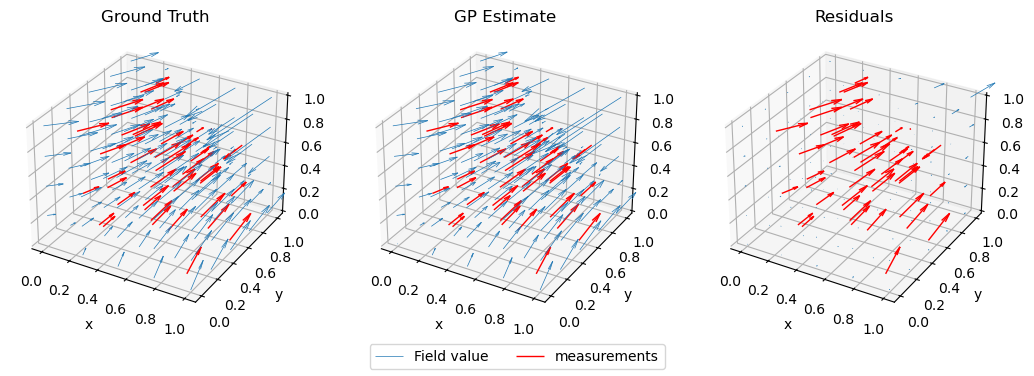

In [20]:
field_comparison_plots(dataset, training_data, dataset_latent_diagonal)

## Curl free kernel

### Derivation of curl free kernel
The latent function $\mathbf f$ was chosen such that it is curl-free, in other words:
$$\boldsymbol \nabla\times \mathbf f := \begin{pmatrix}\dfrac{\partial f_3}{\partial x_2} - \dfrac{\partial f_2}{\partial x_3}\\
\dfrac{\partial  f_1}{\partial x_3} - \dfrac{\partial  f_3}{\partial x_1}\\
\dfrac{\partial  f_2}{\partial x_1}-\dfrac{\partial  f_1}{\partial x_2}\end{pmatrix}=\mathbf 0$$

Note that*, given any differentiable function $g$, the function:
$$\mathbf f(\mathbf x):= \mathscr G_\mathbf x g := \nabla _{\mathbf x} g$$
automatically satisfies the required constraint.

As is the case with multivariate Gaussians, linear transformations of GPs are GPs (and they transform in much the same way).
In particular:
$$g \sim \mathcal{GP}(0, k_g) \implies \mathscr G_\mathbf x g \sim \mathcal{GP}(\mathbf 0, \mathscr G_\mathbf x k_g \mathscr G_{\mathbf x'}^\top)$$

In our case, we choose $k_g$ to be the squared exponential kernel. Therefore, any $\mathbf f$ picked from the distribution $\mathbf f \sim \mathcal {GP}(\mathbf 0, \mathscr G_\mathbf x  k_g(\mathbf x, \mathbf x') \mathscr G_{\mathbf x'}^\top)$, where
$$\mathscr G_\mathbf x  k_g(\mathbf x, \mathbf x') \mathscr G_{\mathbf x'}^\top= \begin{pmatrix}\dfrac{\partial^2}{\partial x_1 x_1'} & \dfrac{\partial^2}{\partial x_1 x_2'} & \dfrac{\partial^2}{\partial x_1 x_3'}\\
\dfrac{\partial^2}{\partial x_2 x_1'} & \dfrac{\partial^2}{\partial x_2 x_2'} & \dfrac{\partial^2}{\partial x_2 x_3'}\\
\dfrac{\partial^2}{\partial x_3 x_1'} & \dfrac{\partial^2}{\partial x_3 x_2'} & \dfrac{\partial^2}{\partial x_3 x_3'}
\end{pmatrix}k_g(\mathbf x, \mathbf x')$$
will satisfy the required constraint. This is the divergence-free kernel.

*Much of the paper is dedicated to devising a systematic way to construct $\mathscr{G}_\mathbf x$ for arbitrary linear constraints.

In [21]:
def small_hessian(
    kernel, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
) -> Float[Array, "1"]:
    # compute all relevant second derivatives at once
    # eg small_hessian(k)[0][1] is d2k/dx1dy2
    return jnp.array(
        jacfwd(jacrev(kernel, argnums=0), argnums=1)(X, Xp), dtype=jnp.float64
    )


@dataclass
class CurlFreeKernel(gpx.kernels.AbstractKernel):
    kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1, 2])

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        axis_1 = jnp.array(X[3], dtype=int)
        axis_2 = jnp.array(Xp[3], dtype=int)

        # drop output label to reduce resource usage
        X = jnp.array(X[0:3])
        Xp = jnp.array(Xp[0:3])

        hess = small_hessian(self.kernel, X, Xp)

        K = hess[axis_1][axis_2]

        return K

In [22]:
kernel = CurlFreeKernel()
curl_free_posterior = initialise_gp(kernel, mean, training_data)

In [23]:
opt_curl_free_posterior = optimise_mll(curl_free_posterior, training_data)

  0%|          | 0/200 [00:00<?, ?it/s]

In [24]:
curl_free_mean, curl_free_std = latent_distribution(
    opt_curl_free_posterior, dataset.X, training_data
)

In [25]:
dataset_latent_curl_free = dataset_5d(positions, curl_free_mean)

In [26]:
rmse(dataset_latent_curl_free.y, dataset.y)

Array(0.03228515, dtype=float64)

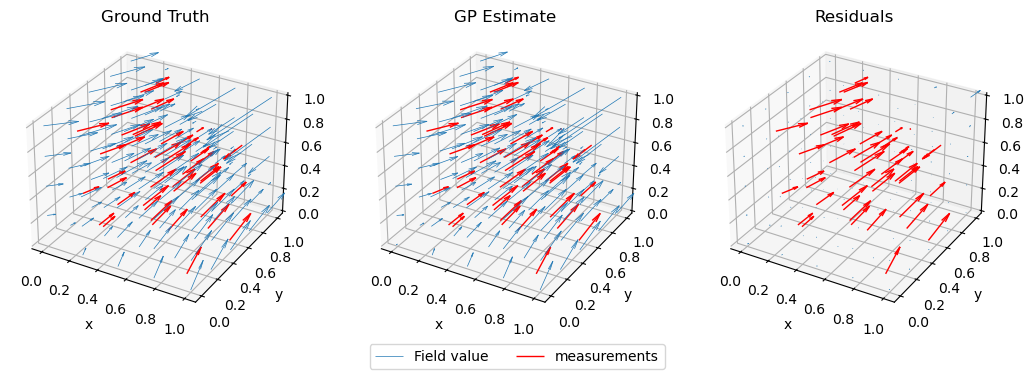

In [27]:
field_comparison_plots(dataset, training_data, dataset_latent_curl_free)

## NLPD (Negative Log Predictive Density)
An alternative to RMSE for measuring how well the predicted model matches the true values. It is formally the log-likelihood of predicting the true values using the model. It is calculated using the following formula:

$$\text{NLPD} = -\sum_{i=1}^{N_P} \log p(\mathbf y_i|\mathbf x_i)$$

Here $p(\mathbf y|\mathbf x)$ is a Gaussian distribution with mean given by the posterior mean and standard deviation given by the posterior standard deviation.

In [28]:
# ensure testing data alternates between x0 and x1 components
def nlpd(mean, std, true_observations):
    test_grid = jnp.column_stack(
        (true_observations[0], true_observations[1], true_observations[2])
    ).flatten()
    normal = tfp.substrates.jax.distributions.Normal(loc=mean, scale=std)
    return -jnp.sum(normal.log_prob(test_grid))


# compute nlpd for velocity and helmholtz
nlpd_diagonal = nlpd(diagonal_mean, diagonal_std, observations)
nlpd_curl_free = nlpd(curl_free_mean, curl_free_std, observations)

print(
    f"NLPD for diagonal: {nlpd_diagonal:.2E} \nNLPD for curl free: {nlpd_curl_free:.2E}"
)

NLPD for diagonal: 4.13E+02 
NLPD for curl free: 1.87E+03


In [29]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a "Neel Maniar and Mate Balogh"

Author: Neel Maniar and Mate Balogh

Last updated: Tue Jun 25 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.12.3

tensorflow_probability: 0.22.1
gpjax                 : 0.8.2
matplotlib            : 3.8.4
optax                 : 0.1.9
jax                   : 0.4.28
numpy                 : 1.24.3

Watermark: 2.4.3

